In [526]:
import pandas as pd
import torch
import numpy as np

from sklearn.model_selection import train_test_split
from utils.covariate_data_processing import pbc2_proccess_covariate, padded_mask_processing

In [ ]:
df = pd.read_csv(
    "/Users/davidlee/Documents/GitHub/Surtimesurvival/Data Project/Pycox Lib/PBC2 Convariate Data/pbc2_data_merged_timegan_auton_covariate.csv")

In [ ]:
df.head()

In [ ]:
df_temp = df.loc[0:, ['seq_id', 'seq_time_id', 'event', 'time']]
df = df.drop(columns=['seq_id', 'seq_time_id'])

In [ ]:
df.head()

In [ ]:
df.rename(columns={'time': 'duration'}, inplace=True)

In [ ]:
y, df, df_train, df_y_train = pbc2_proccess_covariate(df)

In [ ]:
df_train = pd.concat([df_train, df_temp['seq_id']], axis=1, join='inner')
df_y_train = pd.concat([df_y_train, df_temp['seq_id']], axis=1, join='inner')

In [ ]:
masks, padded_patients = padded_mask_processing(df_train)

In [ ]:
padded_patients.shape

In [ ]:
masks.shape

In [ ]:
df_y_train = df_y_train.drop_duplicates(subset='seq_id', keep='last')
df_y_train = df_y_train.reset_index(drop=True)
df_y_train = df_y_train.drop(columns=['seq_id'])

In [ ]:
df_y_train.head()

In [ ]:
df_temp = df_temp.drop_duplicates(subset='seq_id', keep='last')
df_temp = df_temp.reset_index(drop=True)
df_temp = df_temp.drop(columns=['seq_id'])

In [ ]:
df_temp.head()

In [ ]:
X_features_data_tensor = padded_patients
Y_labels_data_tensor = torch.tensor(df_y_train.values)

In [ ]:
Y_labels = Y_labels_data_tensor[:, 1]
Y_labels = Y_labels.long()

In [ ]:
Y_labels

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset

kfold_split = KFold(n_splits=5, random_state=None, shuffle=True)
data_tensor_full = TensorDataset(X_features_data_tensor, Y_labels, masks, torch.tensor(df_temp.values))

In [ ]:
train_list = []
test_list = []

for train, test in kfold_split.split(data_tensor_full):
    train_list.append(data_tensor_full[train])
    test_list.append(data_tensor_full[test])

In [ ]:
print(len(train_list))
print(len(test_list))

In [ ]:
train_tensor_data = train_list[4]
test_tensor_data = test_list[4]

In [ ]:
X_train = train_tensor_data[0]
y_train = train_tensor_data[1]
masks_train = train_tensor_data[2]
df_temp_train = train_tensor_data[3]

X_train, X_val, y_train, y_val, masks_train, masks_val, df_temp_train, df_temp_val = train_test_split(
    X_train, y_train, masks_train, df_temp_train,
    test_size=0.25)

X_test = test_tensor_data[0]
y_test = test_tensor_data[1]
masks_test = test_tensor_data[2]
df_temp_test = test_tensor_data[3]



In [ ]:
df_temp_train = pd.DataFrame(df_temp_train, columns=['seq_time_id', 'event', 'time'])
df_temp_val = pd.DataFrame(df_temp_val, columns=['seq_time_id', 'event', 'time'])
df_temp_test = pd.DataFrame(df_temp_test, columns=['seq_time_id', 'event', 'time'])

In [ ]:
import torch
from torch.utils.data import TensorDataset

# X_train, X_val, y_train, y_val, masks_train, masks_val, df_temp_train, df_temp_val = train_test_split(
#     X_features_data_tensor, Y_labels, masks, df_temp,
#     test_size=0.3)
#
# X_val, X_test, y_val, y_test, masks_val, masks_test, df_temp_val, df_temp_test = train_test_split(X_val, y_val,
#                                                                                                   masks_val,
#                                                                                                   df_temp_val,
#                                                                                                   test_size=0.7)
train_data = TensorDataset(X_train, y_train, masks_train)
val_data = TensorDataset(X_val, y_val, masks_val)
test_data = TensorDataset(X_test, y_test, masks_test)

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from model.survtimesurvival_model import TransformerClassifierFirstSolution, TransformerClassifier

# # Hyperparameters 1
# # input_dim = 26
embed_dim = 16
num_heads = 2
ffn_hidden_dim = 64
num_layers = 2
batch_size = 8
num_classes = 2

# Hyperparameters
# input_dim = 26
# embed_dim = 64
# num_heads = 4
# ffn_hidden_dim = 64
# num_layers = 2
# batch_size = 8
# num_classes = 2

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Set up training configurations
input_dim = X_features_data_tensor.size(2)
seq_length = X_features_data_tensor.size(1)

print("Input Dimension", input_dim)
print("Sequence Length", seq_length)

model = TransformerClassifierFirstSolution(input_dim, seq_length, embed_dim, num_heads, ffn_hidden_dim, num_layers, 2)

In [ ]:
# HUNG: IMPORTANCE. IF YOU KEEP nn.CrossEntropyLoss(), this loss will return a number!!!!
# criterion = torch.nn.NLLLoss(reduction="none")
criterion = torch.nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
# Train the model
num_epochs = 40
train_loss_his = []
val_loss_his = []
val_accuracy_his = []

patience = 3
best_val_loss = None
epochs_since_best_val_loss = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target, label_mask) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data, label_mask)
        loss = criterion(output, target)
        # Assume loss has shape (B, S, D). Assume mask has shape (B, S)
        # Apply label mask to the loss.
        # In the label. Assume 1 is NOT PAD, and 0 is pad.
        loss = (loss * label_mask.unsqueeze(-1).float())

        # Average over the third dimension
        loss = loss.mean(-1)

        # Average over each sequence (dimension 1).
        # Since each sequence has different length. We need to do this
        loss = torch.sum(loss, dim=-1) / torch.sum(label_mask, dim=-1, keepdim=True)

        # Then average over the batch
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for batch_idx, (data, target, masks) in enumerate(val_loader):
            output = model(data, masks)
            loss = criterion(output, target)
            # val_running_loss += loss.item()
            val_running_loss += loss.sum().item()
            # val_running_loss += loss.mean().item()
            preds = output.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(target.cpu().numpy())

    # Calculate the accuracy of the model on the validation set
    val_accuracy = accuracy_score(val_targets, val_preds)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {running_loss / len(train_loader)}, "
          f"Validation Loss: {val_running_loss / len(val_loader)}, "
          f"Validation Accuracy: {val_accuracy}")

    train_loss_his.append(running_loss / len(train_loader))
    val_loss_his.append(val_running_loss / len(val_loader))
    val_accuracy_his.append(val_accuracy)
    if best_val_loss is None or abs(val_running_loss) < abs(best_val_loss):
        best_val_loss = val_running_loss
        epochs_since_best_val_loss = 0
    else:
        epochs_since_best_val_loss += 1

    if epochs_since_best_val_loss > patience:
        print(f"Early stopping triggered. No improvement in validation loss for {patience} consecutive epochs.")
        break

In [ ]:
torch.save(model.state_dict(), 'pre_trained_timevisit_seperatedtesting.pth')

In [ ]:
from model.survtimesurvival_model import TransformerClassifier_2

In [ ]:
model = TransformerClassifier_2(input_dim, seq_length, embed_dim, num_heads, ffn_hidden_dim, num_layers, num_classes)
pretrained_weights = torch.load('pre_trained_timevisit_seperatedtesting.pth')
#pretrained_weight/
model.load_state_dict(pretrained_weights)

In [ ]:
# masks, padded_patients = padded_mask_processing(df_train)

In [ ]:
new_embedding_train = []
new_embedding_val = []
new_embedding_test = []

for i in range(len(masks_train)):
    a = masks_train[i].unsqueeze(0)
    output = model(X_train[i], a)
    new_embedding_train.append(output)

for i in range(len(masks_val)):
    a = masks_val[i].unsqueeze(0)
    output = model(X_val[i], a)
    new_embedding_val.append(output)

for i in range(len(masks_test)):
    a = masks_test[i].unsqueeze(0)
    output = model(X_test[i], a)
    new_embedding_test.append(output)

In [ ]:
# Convert each tensor to a numpy array and stack them - training
numpy_arrays_train = [tensor.detach().numpy() for tensor in new_embedding_train]
numpy_array_train = np.stack(numpy_arrays_train, axis=-1)  # this stacks along a new third dimension

# Convert each tensor to a numpy array and stack them - validating
numpy_arrays_val = [tensor.detach().numpy() for tensor in new_embedding_val]
numpy_array_val = np.stack(numpy_arrays_val, axis=-1)  # this stacks along a new third dimension

# Convert each tensor to a numpy array and stack them - test
numpy_arrays_test = [tensor.detach().numpy() for tensor in new_embedding_test]
numpy_array_test = np.stack(numpy_arrays_test, axis=-1)  # this stacks along a new third dimension

In [ ]:
new_df_train = pd.DataFrame(numpy_array_train[0])
new_df_train = new_df_train.transpose()

new_df_val = pd.DataFrame(numpy_array_val[0])
new_df_val = new_df_val.transpose()

new_df_test = pd.DataFrame(numpy_array_test[0])
new_df_test = new_df_test.transpose()

In [ ]:
df_temp_train = df_temp_train.reset_index(drop=True)
df_temp_val = df_temp_val.reset_index(drop=True)
df_temp_test = df_temp_test.reset_index(drop=True)

In [ ]:
df_temp_train.head()

In [ ]:
new_df_train.head()

In [ ]:
dataframe_for_survtrace_train = pd.concat([new_df_train, df_temp_train], axis=1)
dataframe_for_survtrace_val = pd.concat([new_df_val, df_temp_val], axis=1)
dataframe_for_survtrace_test = pd.concat([new_df_test, df_temp_test], axis=1)

In [ ]:
# new_embedding = []
# for i in range(len(masks)):
#     a = masks[i].unsqueeze(0)
#     output = model(X_features_data_tensor[i], a)
#     new_embedding.append(output)

In [ ]:
# # Convert each tensor to a numpy array and stack them
# numpy_arrays = [tensor.detach().numpy() for tensor in new_embedding]
# numpy_array = np.stack(numpy_arrays, axis=-1) # this stacks along a new third dimension

In [ ]:
# new_df = pd.DataFrame(numpy_array[0])
# new_df = new_df.transpose()

In [ ]:
# dataframe_for_survtrace = pd.concat([new_df, df_y_train], axis=1)

In [ ]:
# dataframe_for_survtrace.head()

In [ ]:
# df_temp.head()

In [ ]:
dataframe_for_survtrace_train.head()

In [ ]:
location_test = dataframe_for_survtrace_test.shape[0]
print(location_test)

In [ ]:
dataframe_for_survtrace = pd.concat(
    [dataframe_for_survtrace_test, dataframe_for_survtrace_val, dataframe_for_survtrace_train])
dataframe_for_survtrace.columns = dataframe_for_survtrace.columns.astype(str)
dataframe_for_survtrace = dataframe_for_survtrace.drop(columns=['seq_time_id'])
dataframe_for_survtrace.rename(columns={'time': 'duration'}, inplace=True)

In [ ]:
dataframe_for_survtrace.columns

In [ ]:
dataframe_for_survtrace = dataframe_for_survtrace.reset_index(drop=True)

In [ ]:
# dataframe_for_survtrace = pd.concat([dataframe_for_survtrace, df_temp['seq_time_id']], axis=1)

In [ ]:
# dataframe_for_survtrace.rename(columns={'proportion': 'proportion_1'}, inplace=True)
# dataframe_for_survtrace.columns = dataframe_for_survtrace.columns.astype(str)

In [ ]:
# df_2 = dataframe_for_survtrace.drop(columns=['duration', 'proportion_1'])
# df_2.rename(columns={'seq_time_id': 'duration'}, inplace=True)

In [ ]:
# df_2.info()

In [ ]:
from utils.covariate_data_processing import pbc2_proccess_covariate_firstsolution

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# dataframe_for_survtrace.rename(columns={'proportion': 'proportion_1'}, inplace=True)
# dataframe_for_survtrace.columns = dataframe_for_survtrace.columns.astype(str)

In [ ]:
# df_2 = dataframe_for_survtrace.drop(columns=['duration', 'proportion_1'])
# df_2.rename(columns={'seq_time_id': 'duration'}, inplace=True)

In [ ]:
# df_2.info()

In [ ]:
from utils.covariate_data_processing import pbc2_proccess_covariate_firstsolution

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# df_2 = dataframe_for_survtrace.drop(columns=['duration', 'proportion_1'])
# df_2.rename(columns={'seq_time_id': 'duration'}, inplace=True)

In [ ]:
# df_2.info()

In [ ]:
from utils.covariate_data_processing import pbc2_proccess_covariate_firstsolution

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
# df_2.info()

In [ ]:
from utils.covariate_data_processing import pbc2_proccess_covariate_firstsolution

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
from utils.covariate_data_processing import pbc2_proccess_covariate_firstsolution

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

In [ ]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [ ]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

In [ ]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [561]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(
    dataframe_for_survtrace, location_test)

0
______
21
______
0
______
21
______
0
______
[2.73792575e-03 1.67697952e-01 4.91509609e-01 4.91987332e-01
 1.43056620e+01]
______
4


/Users/davidlee/Documents/GitHub/Surtimesurvival/SurvTRACE/survtrace/utils.py:78: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


In [562]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 8,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [563]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

GPU not found! will use cpu for training!
[Train-0]: 58.733633041381836
[Val-0]: 1.4266263246536255
[Train-1]: 34.82881546020508
[Val-1]: 0.9858821630477905
[Train-2]: 32.124745428562164
[Val-2]: 0.9804132580757141
[Train-3]: 32.34340858459473
[Val-3]: 0.9145658612251282
[Train-4]: 30.522722274065018
[Val-4]: 0.9292930960655212
EarlyStopping counter: 1 out of 5
[Train-5]: 30.554396241903305
[Val-5]: 0.9420157074928284
EarlyStopping counter: 2 out of 5
[Train-6]: 30.361992061138153
[Val-6]: 0.8356114029884338
[Train-7]: 28.095417395234108
[Val-7]: 0.8813571333885193
EarlyStopping counter: 1 out of 5
[Train-8]: 27.015373326838017
[Val-8]: 0.912885308265686
EarlyStopping counter: 2 out of 5
[Train-9]: 28.864221692085266
[Val-9]: 0.8798874616622925
EarlyStopping counter: 3 out of 5
[Train-10]: 29.52144768834114
[Val-10]: 0.8590208292007446
EarlyStopping counter: 4 out of 5
[Train-11]: 28.266199737787247
[Val-11]: 0.8382585048675537
EarlyStopping counter: 5 out of 5
early stops at epoch 12


In [564]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

******************************
start evaluation
******************************
For 0.25 quantile,
TD Concordance Index - IPCW: 0.8365570599613152
Brier Score: 0.08579369202947419
For 0.5 quantile,
TD Concordance Index - IPCW: 0.8547486033519553
Brier Score: 0.1290126610134401
For 0.75 quantile,
TD Concordance Index - IPCW: 0.8013779368467248
Brier Score: 0.19708083379149133
done


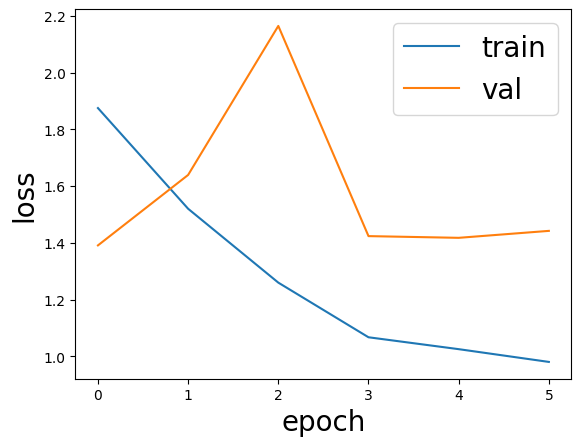

In [268]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()